In [1]:
from utils import * 
from algorithms import *
from agents import *

In [2]:
numRounds, numPeriods, numSteps = 1, 10000, 10
numBuyers, numSellers, numTokens = 4, 4, 4
gameTypes, seed = '1111', 42
disclosure = ['bids', 'asks', 'currentBid', 'currentBidIdx','currentAsk', 'currentAskIdx', 'buy', 'sell', 'price', 'sale']
depth = 1
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
numStates=18; lr_pi=0.0003; lr_q=0.0003;  gamma=0.99; batch_size=64; buffer_limit = 50000;
target_entropy = -1.0; init_alpha = 0.01; lr_alpha = 0.0003; wait_period = 100; grad_steps = 1;
buyers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0)]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)]
log = Log(gameData, disclosure)
rnd = 0

In [17]:
import gymnasium as gym
from gymnasium import spaces
class TradingEnv(gym.Env):
    def __init__(self, log,render_mode = None, num_envs = 1):
        self.num_envs = 1
        self.rnd = 0
        self.period = -1
        self.numPeriods = numPeriods
        self.numSteps = numSteps
        self.log = log
        state_mean = np.loadtxt('mean.csv', delimiter=',')
        state_std = np.loadtxt('std.csv', delimiter=',')
        self.state_mean = np.array(state_mean,dtype=np.float64)
        self.state_std = np.array(state_std,dtype=np.float64)
        self.action_space = spaces.Box(-1,1,(1,),dtype=np.float64)
        self.observation_space = spaces.Box(-3,3,(numStates,),dtype=np.float64)

    def reset(self,seed=None):
        startRounds(gameData, log, buyers, sellers, rnd)
        startPeriods(buyers, sellers)
        state = generateState(buyers[0], disclosure, depth)
        state = (state - self.state_mean)/(self.state_std + 1e-8)
        self.timestep = 0
        self.period += 1
        return state, {}

    def step(self, action, seed=None, options=None):
        startSteps(buyers, sellers)
        bid_frac = (action.item()+1)/2
        min_bid = buyers[0].stepTokenValue * 0.1
        max_bid = buyers[0].stepTokenValue * 1.0
        bid = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        bids, asks = collectOffers(buyers, sellers)
        bids[0] = bid
        currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
        price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
        bprofit, sprofit = 0, 0
        if price > 0:
            buyers[currentBidIdx].transact(price)
            sellers[currentAskIdx].transact(price)
            bprofit = buyers[currentBidIdx].stepProfits
            sprofit = sellers[currentAskIdx].stepProfits
    
        self.log.addStep([self.rnd, self.period, buyers[0].periodSteps, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
        observe(buyers, sellers, log.disclose())
        endSteps(buyers, sellers)
        newState = generateState(buyers[0], disclosure, depth)
        newState = (newState - self.state_mean)/(self.state_std + 1e-8)
        if buyers[0].periodSteps == numSteps - 1:
            terminated = True
            endPeriods(buyers, sellers)
            self.period+=1
        else:
            terminated = False
    
        # compute reward, new state
        reward = 0.0
        if currentBidIdx == 0:
            reward = bprofit
        
        infos = {"TimeLimit.truncated":True}
        truncated = False
        return newState, reward, terminated, truncated, infos

In [18]:

from stable_baselines3.common.env_checker import check_env
env = TradingEnv(log)
check_env(env)

In [19]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, VecFrameStack, VecNormalize
#env = VecNormalize(env)
env = Monitor(env, allow_early_resets=True)
np.random.seed(123)
env = DummyVecEnv([lambda: env]) 
env = VecFrameStack(env, n_stack=4)

NameError: name 'Monitor' is not defined

In [20]:
from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
log = Log(gameData, disclosure)
env = TradingEnv(log)
#env = VecNormalize(env)
policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
model = SAC("MlpPolicy", env,  verbose=1)
model.learn(50000, progress_bar = False)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 60.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 170      |
|    time_elapsed    | 0        |
|    total_timesteps | 36       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 53       |
| time/              |          |
|    episodes        | 8        |
|    fps             | 172      |
|    time_elapsed    | 0        |
|    total_timesteps | 72       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 47.4     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

KeyboardInterrupt: 

In [34]:
env.log.stepData

,rnd,period,step,bids,asks,currentBid,currentBidIdx,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
0,0,0,0,"[46.37, 66.3, 47.5, 73.7]","[44.4, 60.7, 59.3, 51.7]",73.70,3,44.4,0,True,True,59.050,True,22.734557,16.203759
1,0,0,1,"[50.3, 78.1, 71.0, 66.3]","[63.1, 42.1, 50.5, 49.8]",78.10,1,42.1,1,True,True,60.100,True,25.902861,19.484515
2,0,0,2,"[77.57, 66.4, 55.4, 40.8]","[52.6, 54.7, 58.4, 62.1]",77.57,0,52.6,0,True,True,65.085,True,20.737026,19.531905
3,0,0,3,"[80.66, 60.2, 46.6, 65.7]","[63.3, 60.3, 59.3, 58.7]",80.66,0,58.7,3,True,True,69.680,True,12.050018,22.607320
4,0,0,4,"[31.82, 58.4, 42.7, 42.5]","[46.6, 62.1, 49.5, 60.1]",58.40,1,46.6,0,True,True,52.500,True,29.258515,6.616825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,0,1062,3,"[81.05, 65.2, 43.8, 61.2]","[59.1, 55.0, 59.3, 50.5]",81.05,0,50.5,3,True,True,65.775,True,15.855775,17.842866
4783,0,1062,4,"[73.63, 68.5, 60.2, 67.4]","[59.1, 56.1, 44.2, 69.0]",73.63,0,44.2,2,True,True,58.915,True,19.073028,16.113802
4784,0,1062,5,"[nan, 59.1, 77.6, 63.7]","[57.9, 47.9, 69.7, 51.9]",77.60,2,47.9,1,True,True,62.750,True,20.496075,15.667183
4785,0,1062,6,"[nan, 56.5, 44.1, 80.7]","[46.0, 66.1, 64.6, 54.9]",80.70,3,46.0,0,True,True,63.350,True,18.434557,17.796905


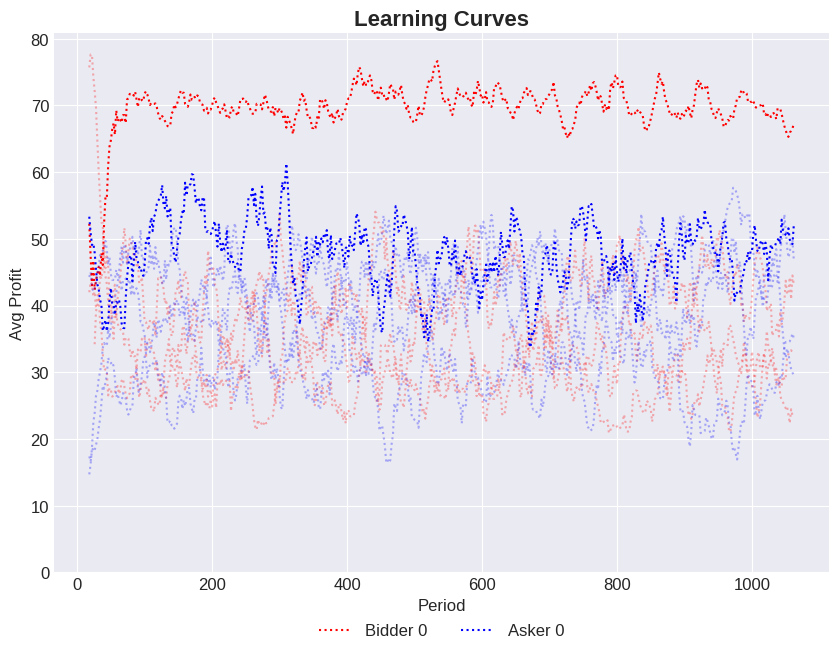

In [22]:
env.log.graphLearning(rolling_window = 10, trackBuyersIdx=[0], trackSellersIdx=[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

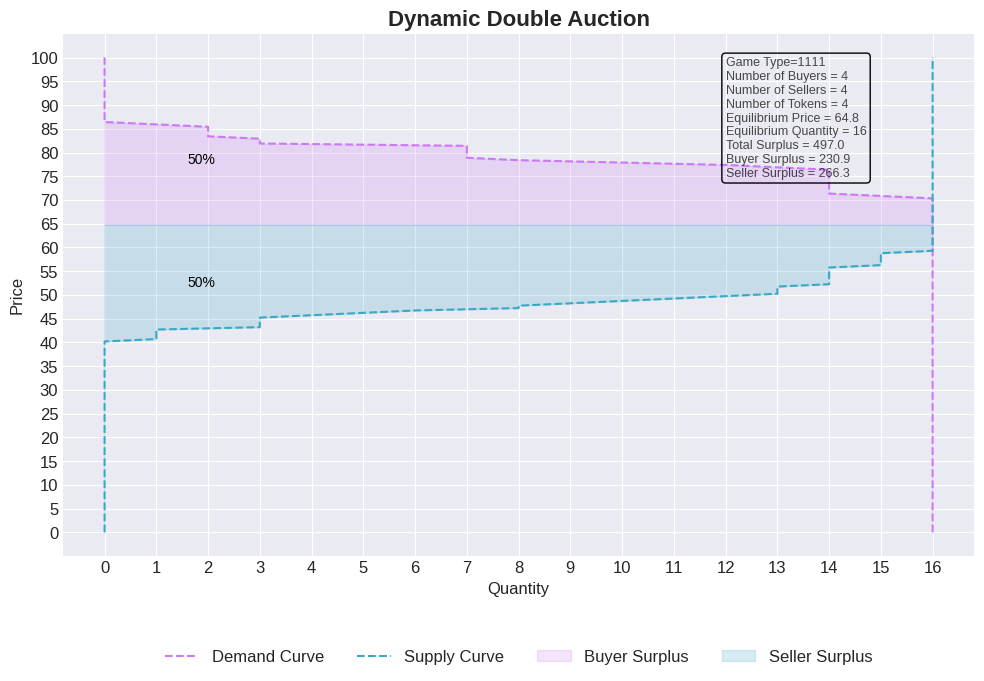

In [36]:
env.log.graphSales(0, 1061, trackBuyersIdx=[], trackSellersIdx=[])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

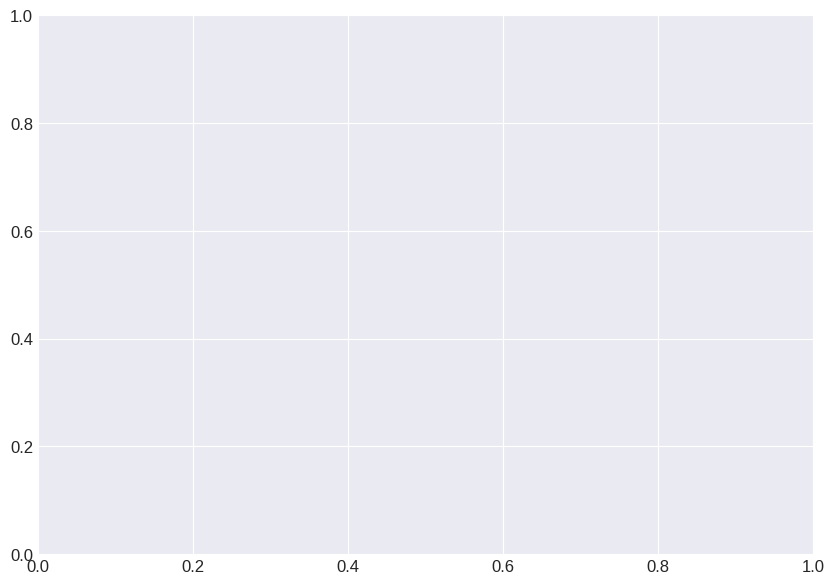

In [38]:
log.graphOffers(0, 101, trackBuyersIdx=[0], trackSellersIdx=[])

In [12]:
log.graphTraining(maxNumPeriods=period-1, skip = int((period-1)/20), trackBuyersIdx = [0])

In [39]:
from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
log = Log(gameData, disclosure)
env = TradingEnv(log)
#env = VecNormalize(env)
policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
model = PPO("MlpPolicy", env,  verbose=1)
model.learn(50000, progress_bar = False)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 48.4     |
| time/              |          |
|    fps             | 99       |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9           |
|    ep_rew_mean          | 50.3        |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017423823 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
model.learn(50000, progress_bar = False)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 77.8     |
| time/              |          |
|    fps             | 7        |
|    iterations      | 1        |
|    time_elapsed    | 257      |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9          |
|    ep_rew_mean          | 78.9       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 2          |
|    time_elapsed         | 526        |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00866461 |
|    clip_fraction        | 0.0807     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.125     |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0003     |
|   

In [ ]:
log.graphOffers(0, 101, trackBuyersIdx=[0], trackSellersIdx=[])